# Implementation of van der Horst deconvolution

Attempted implementation of <div class="csl-entry">van der Horst, J., &#38; Kalkman, J. (2016). Image resolution and deconvolution in optical tomography. <i>Optics Express</i>, <i>24</i>(21), 24460. https://doi.org/10.1364/oe.24.024460</div>

Procedure
1. Perform FBP reconstruction of sinogram
2. Determine parameterisation of PSF (including Gaussian beam parameters)
3. Convert image into polar coordinates $(r, \theta)$ by interpolation
   * Interpl2d only gives you points back on a mesh
4. Deconvolve using Lucy-Richardson method

## Point Spread Function
The position-dependent tomographic point spread function (PSF), based on a Gaussian beam model, is

$$PSF(u,v) = \sqrt{\frac{1}{\pi^2a_ua_v}}\exp\bigg(-\bigg[\frac{u^2}{a_u} + \frac{v^2}{a_v}\bigg]\bigg)$$

where
* $r_0 = \sqrt{x_0^2 + y_0^2}$ where $(x_0, y_0)$ are coordinates of the point object
* $u$ is the radial and $v$ is the tangential coordinate, shifted to be on the object
* $a_u = w_0^2/2$
* $a_v = (w_0^2 + \frac{\lambda^2 r_0^2}{\pi^2w_0^2}) / 2$

* Gaussian beam parameters: $w_0$ is the beam waist and $\lambda$ is the wavelength

In the Gaussian beam tomographic model, the radial spread, quantified by $a_u$ is position invariant, whereas the tangential spread, parameterised by $a_v$ varies. There will be large tangential spread further away from the centre due to the effects of defocusing. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib
matplotlib.rcParams['image.cmap'] = 'hot'
from scipy.ndimage import rotate

In [3]:
def PSF(u, v, r0):
    # (u,v) are parameters in a shifted and rotated coordinate system, representing the radial 
    # and tangential directions in the reconstructed image
    # r_0 is the radial position of the point the PSF describes
    
    # Define parameters
    lamb = 500e-9 # wavelength (m)
    w0 = 6e-6 # Beam waist (m)

    # Coordinates in plane polars
    # r0 = 0 # 
    theta0 = 0 # Angle from x axis to point

    # Evaluation
    au = w0*w0/2
    av = (w0*w0 + lamb**2*r0**2/(np.pi**2* w0**2)) /2
    prefactor = np.sqrt(1/(np.pi*np.pi*au*av ))
    function = np.exp(-(u**2/au + v**2/av ))
    return prefactor * function

Text(0.5, 0, 'Tangential coordinate $v$/ $\\mu m$')

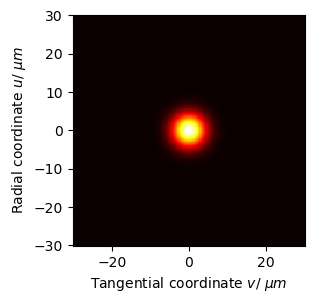

In [4]:
u = np.linspace(-30,30,200)*1e-6
v = u.copy()
uu, vv = np.meshgrid(u,v)
plt.figure(figsize=(3,3))
plt.pcolormesh(vv*1e6,uu*1e6,PSF(uu,vv, 0e-6), shading='auto')
plt.ylabel('Radial coordinate $u$/ $\mu m$')
plt.xlabel('Tangential coordinate $v$/ $\mu m$')
# plt.colorbar()

Text(0.5, 0, 'Tangential coordinate $v$/ $\\mu m$')

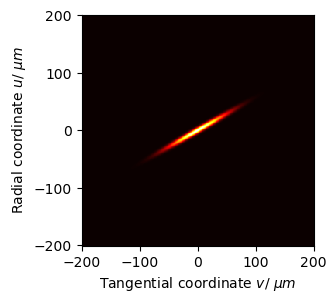

In [5]:
u = np.linspace(-200,200,300)*1e-6
v = u.copy()
uu, vv = np.meshgrid(u,v)
plt.figure(figsize=(3,3))
plt.pcolormesh(vv*1e6,uu*1e6,rotate(PSF(uu,vv, 3e-3), 30, reshape=False), shading='auto')
plt.ylabel('Radial coordinate $u$/ $\mu m$')
plt.xlabel('Tangential coordinate $v$/ $\mu m$')
# plt.colorbar()

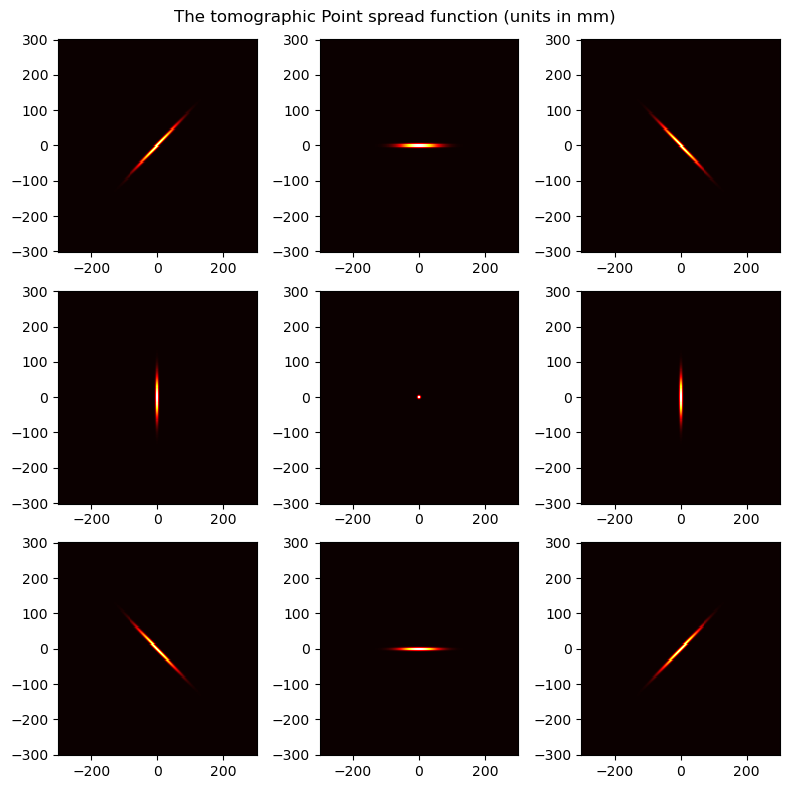

In [6]:
fig, axs = plt.subplots(3,3, figsize=(8,8))

u = np.linspace(-300,300,200)*1e-6
v = u.copy()
uu, vv = np.meshgrid(u,v)

xs = np.array([-3, 0,3 ])*1e-3 *np.array([1,1,1])[:,np.newaxis]
ys = xs.copy().T

for i in range(9):
    x = xs.reshape(-1)[i]
    y = ys.reshape(-1)[i] 
    r_0 = np.sqrt(x**2 + y**2)
    # print(r_0)
    ax = axs.reshape(-1)[i]
    angle = np.arctan2(x,y)/np.pi*180
    ax.pcolormesh(vv*1e6,uu*1e6, rotate(PSF(uu,vv, r_0), angle=angle, reshape=False), shading='auto')
    # ax.set_ylabel('Radial coordinate $u$/ $\mu m$')
    # ax.set_xlabel('Tangential coordinate $v$/ $\mu m$')
plt.suptitle('The tomographic Point spread function (units in mm)')
plt.tight_layout()


Units are in microns

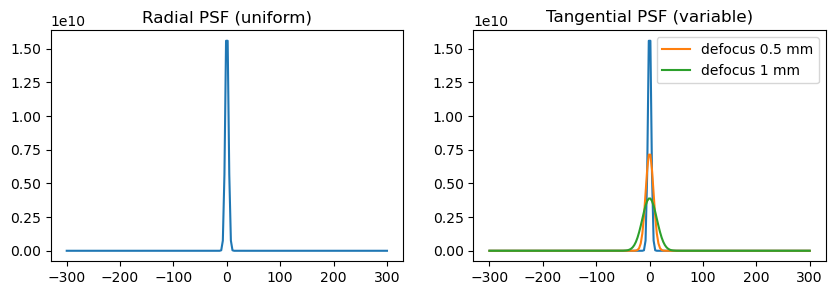

In [49]:
# In radial direction

fig, ax = plt.subplots(1,2, figsize=(10, 3))
ax[0].set_title('Radial PSF (uniform)')
ax[0].plot(u*1e6, PSF(u, 0,0))
ax[0].set_xlabel('')
ax[1].set_title('Tangential PSF (variable)')
ax[1].plot(v*1e6, PSF(0,v,0))
ax[1].plot(v*1e6, PSF(0,v,.5e-3), label='defocus 0.5 mm')
ax[1].plot(v*1e6, PSF(0,v,1e-3), label='defocus 1 mm')

plt.legend()

## Coordinate Transforms

Create test image for reconstruction. Include a centred circle and some straight lines to see whether they are reproducible or not.

Text(0, 0.5, 'y')

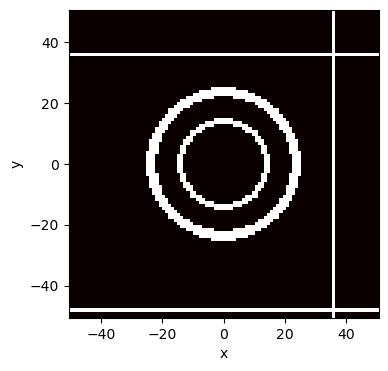

In [6]:
# Generate test image for reconstruction
image = np.zeros((100,100))
image[2,:] = 1
image[-15,:] = 1
image[:,-15] = 1
# plt.imshow(image) 

size = np.shape(image)[0]
x = np.linspace(-size//2, size//2, size)
y = x.copy()
xx, yy = np.meshgrid(x, y)
z = image


z[np.sqrt(xx**2 + yy**2)< 25] = 1
z[np.sqrt(xx**2 + yy**2)< 22] = 0

z[np.sqrt(xx**2 + yy**2)< 15] = 1
z[np.sqrt(xx**2 + yy**2)< 13] = 0
# plt.imshow(z)

# Create interpolant
f = interpolate.interp2d(x, y, z, kind='linear')

# Plot interpolated function
plt.figure(figsize=(4,4))
plt.pcolormesh(x,y, f(x,y), shading='auto')
plt.xlabel('x')
plt.ylabel('y')
# plt.colorbar()

Text(0, 0.5, 'y')

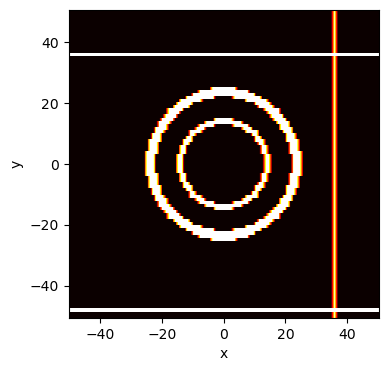

In [7]:
# Plot interpolated function
xnew = np.linspace(-size//2, size//2, 4*size)
ynew = x.copy()
plt.figure(figsize=(4,4))
plt.pcolormesh(xnew,ynew, f(xnew,ynew), shading='auto')
plt.xlabel('x')
plt.ylabel('y')

Transform into plane polars by interpolation

We want a grid where $v/ \theta$ and $u / r$ are evenly sampled.

$$x = r\cos(\theta)$$
$$y = r\sin(\theta)$$

Text(0, 0.5, 'Radial coordinate $u$')

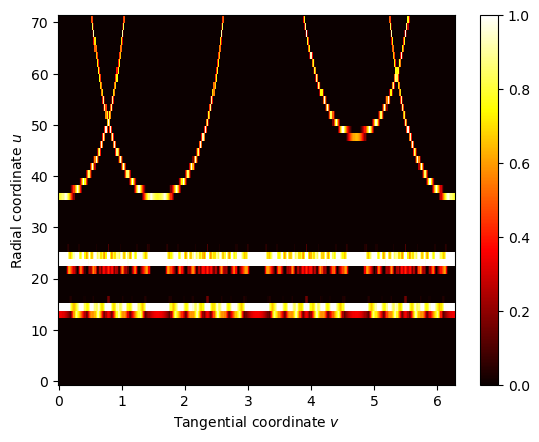

In [8]:
# Transform into plane polars (r, theta)
# r goes from 0 to sqrt(x_max**2 + y_max**2)
# theta goes from 0 to 360
r_max = np.sqrt(2)*size/2
r = np.linspace(0, r_max)
theta = np.arange(0,360, 1)/360 * 2*np.pi

# Multiply and broadcast
xs = (r[:, np.newaxis]*np.cos(theta[np.newaxis,:]))
ys = (r[:, np.newaxis]*np.sin(theta[np.newaxis,:]))

xs = xs.flatten()
ys = ys.flatten()

result = np.zeros(len(ys))
for i in range(len(xs)):
    result[i]= f(xs[i], ys[i])

plt.pcolormesh(theta,r ,result.reshape((50,360)), shading='auto')
plt.colorbar()
plt.xlabel('Tangential coordinate $v$')
plt.ylabel('Radial coordinate $u$')

Interpolate result

In [9]:
# Create interpolant
g = interpolate.interp2d(theta,r, result.reshape((50,360)), kind='linear')

Transform back to Cartesian coordinates

We want an even sampling of $x$ and $y$.
$$u = \sqrt{x^2 + y^2} $$
$$v = \arctan \bigg(\frac{y}{x}\bigg)$$

In [10]:
us = np.sqrt(x[np.newaxis,:]**2 + y[:, np.newaxis]**2)
vs = np.arctan2(y[:, np.newaxis], x[np.newaxis,:]) + np.pi

us = us.flatten()
vs = vs.flatten()

result_cartesian = np.zeros(len(us))
for i in range(len(us)):
    result_cartesian[i]= g(vs[i], us[i])

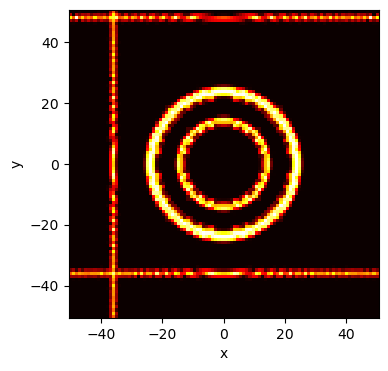

In [11]:
# Plot interpolated function
plt.figure(figsize=(4,4))
plt.xlabel('x')
plt.ylabel('y')

plt.pcolormesh(x,y, result_cartesian.reshape((100,100)),  shading='auto')

It is possible to c

## Deconvolution

We use the Lucy-Richardson method of deconvolution.
* First proposed in William Hadley Richardson, "Bayesian-Based Iterative Method of Image Restoration*," J. Opt. Soc. Am. 62, 55-59 (1972)
* The algorithm is based on maximizing the likelihood that the resulting image J is an instance of the original image I under Poisson statistics. (MATLAB site)

Implementation details
* van der Horst and Kalkman performed the deconvolution for 100 iterations.
* According to The image can be successively deconvolved in the radial and angular direction using deconvolu-tion (e.g., with the Lucy–Richardson algorithm) 

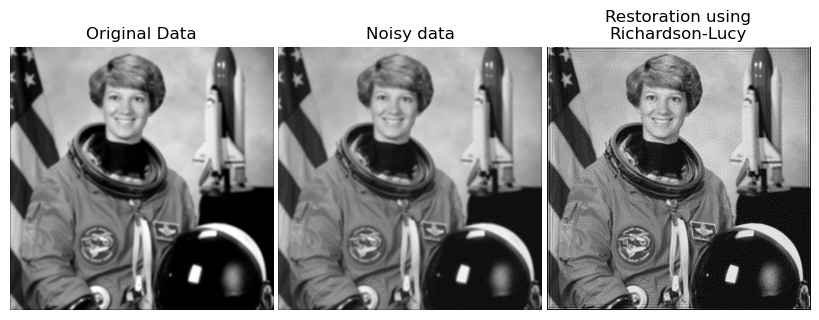

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

rng = np.random.default_rng()

astro = color.rgb2gray(data.astronaut())

psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, num_iter=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

To do

* Do inverse transform to verify code.
* Deconvolution may just be 1D in the thing, so it technically isn't 2D?

In [13]:
def catesian_to_polar(array):
    # Input: square array
    # Need to resample
    # Output: 
    return